In [27]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [28]:
df=pd.read_csv('diabetes.csv')

In [29]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [30]:
df.shape

(768, 9)

<Axes: xlabel='Outcome', ylabel='count'>

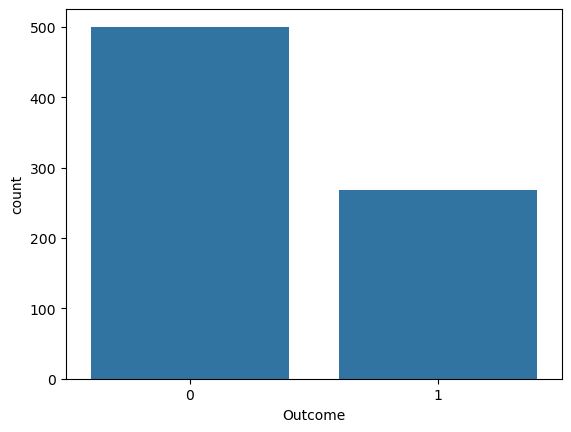

In [31]:
sns.countplot(x=df['Outcome'])

In [32]:
con_col=['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

In [33]:
cols_with_zero_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zero_missing:
    means=df[col].mean()
    df[col] = df[col].replace(0, means)

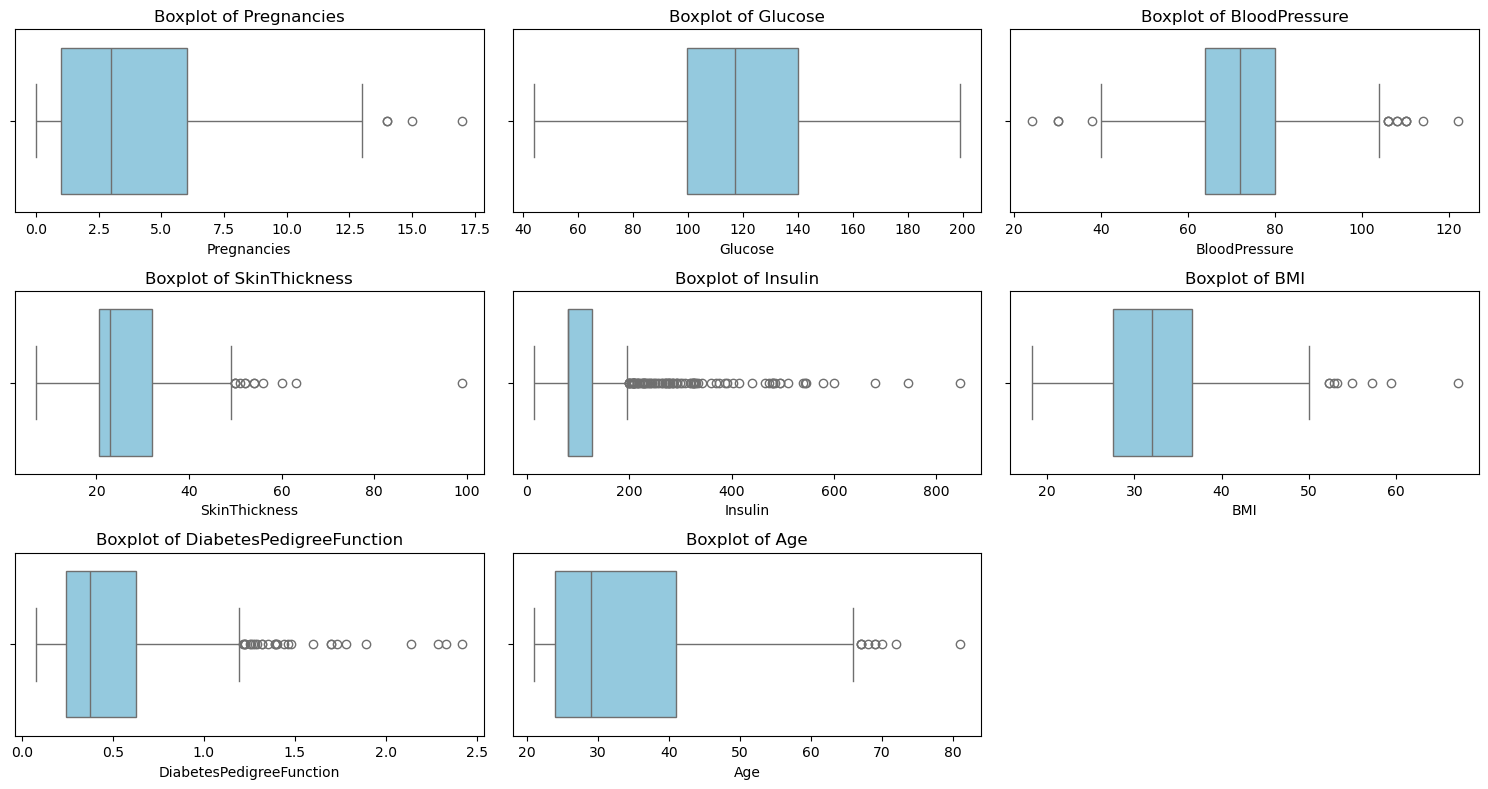

In [34]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


In [35]:
def replace_outliers(df, cols):
    df_capped = df.copy()
    for col in cols:
        means=df[col].mean()
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_capped[col] = np.clip(df[col], lower, upper)
    return df_capped

In [36]:
diabetes_capped = replace_outliers(df, con_col)

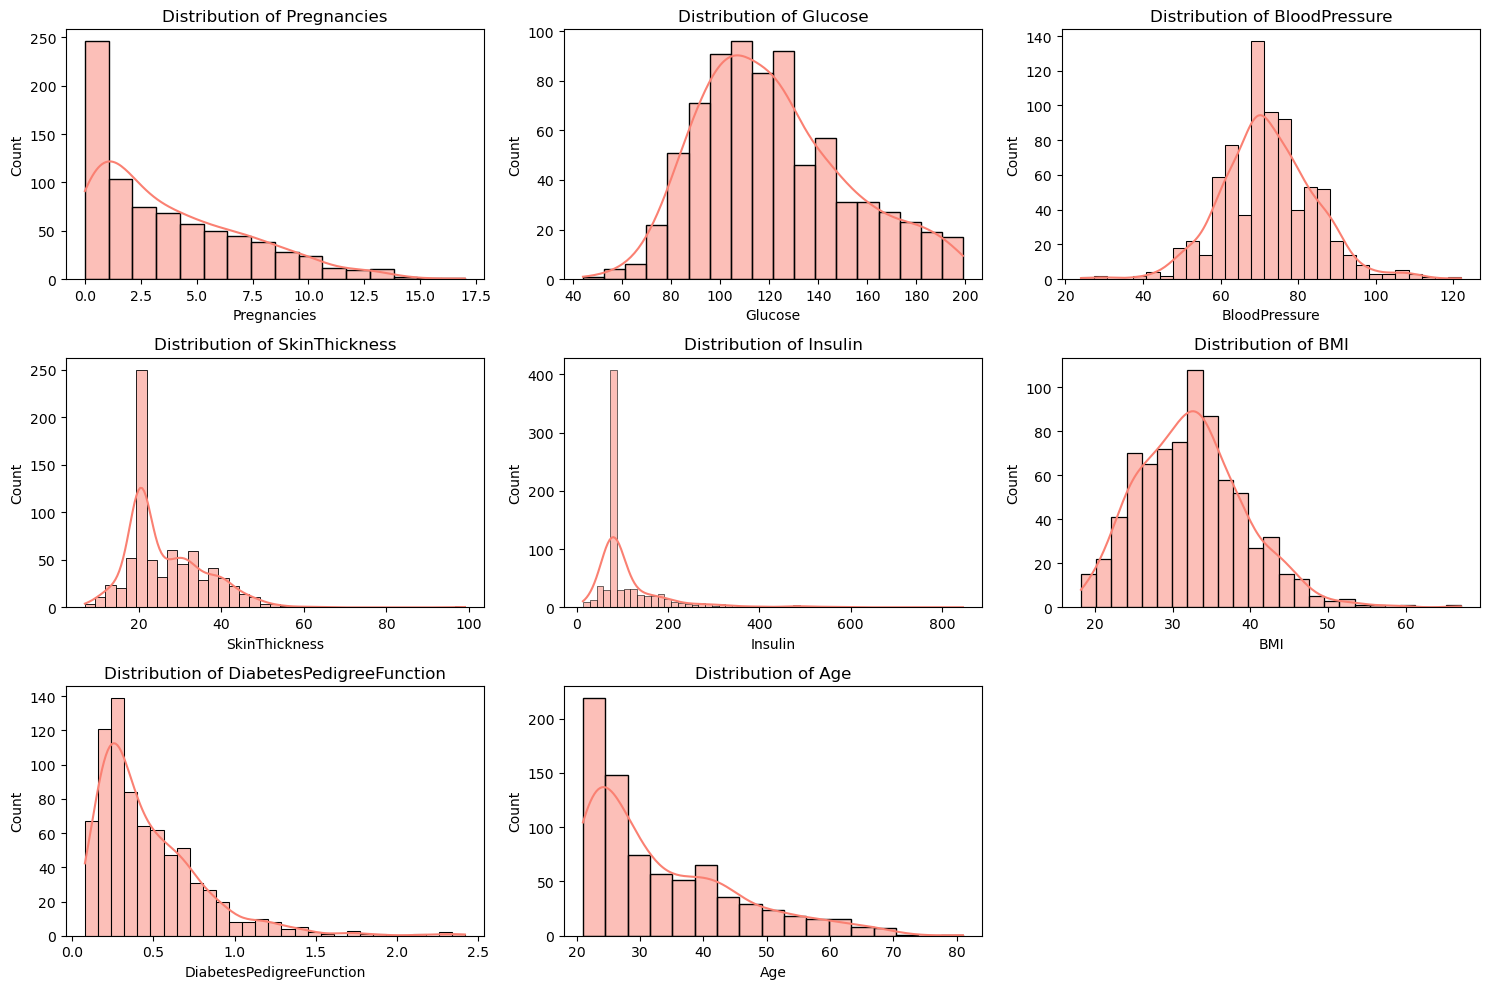

In [37]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color='salmon')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


In [38]:
con_col

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [39]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
# Fit on numeric columns only
diabetes_capped[con_col] = pt.fit_transform(diabetes_capped[con_col])

In [40]:
import pickle
with open('Transformation.pkl', 'wb') as f:
        pickle.dump(pt, f)


In [41]:
df=diabetes_capped

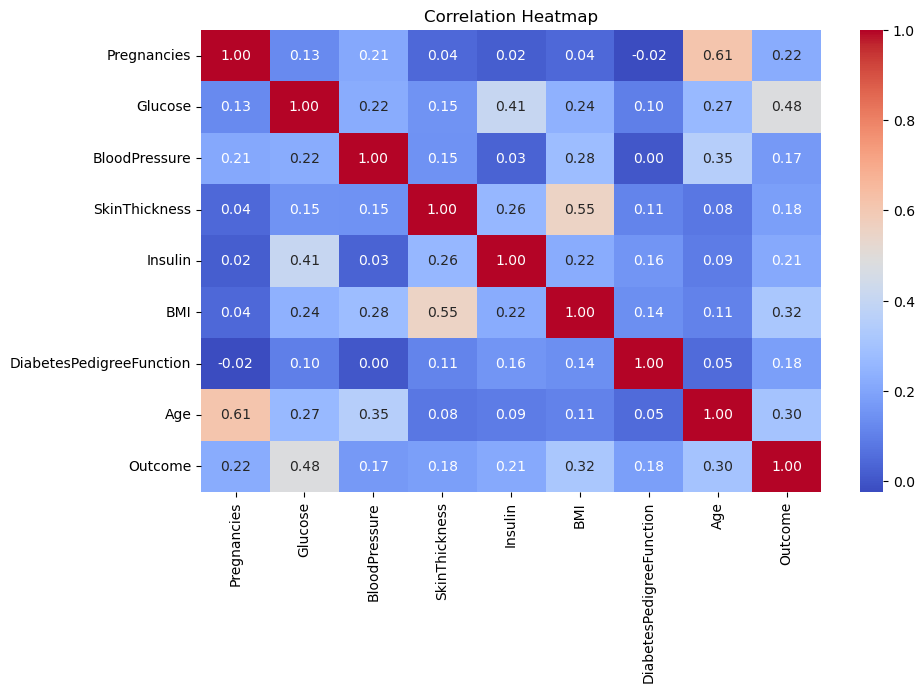

In [42]:
plt.figure(figsize=(10, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


# Model-Fit

In [43]:
X=df.drop('Outcome',axis=1)
y=df['Outcome']

In [44]:
from imblearn.over_sampling import RandomOverSampler
smote = RandomOverSampler()
X_train_res, y_train_res = smote.fit_resample(X, y)
X=X_train_res
y=y_train_res

In [45]:
from sklearn.preprocessing import StandardScaler
num_cols = X.select_dtypes(include=['number']).columns.tolist()
scaler=StandardScaler()
X[num_cols]=scaler.fit_transform(X[num_cols])

In [46]:
with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)


In [47]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [48]:
import os
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime
from mlflow.models import infer_signature


In [49]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

results = {}
best_model = None
best_name = None
best_acc = 0.0


In [50]:
mlflow_dir = os.path.join(os.getcwd(), "mlruns")
os.makedirs(mlflow_dir, exist_ok=True)

mlflow.set_tracking_uri(f"file:///{mlflow_dir}")
mlflow.set_experiment("Diabetes_Classification_Comparison")


<Experiment: artifact_location='file:///C:\\Users\\Ashvitta\\OneDrive\\Desktop\\gitprograms\\Diabetes\\mlruns/951276405022986932', creation_time=1761663620762, experiment_id='951276405022986932', last_update_time=1761663620762, lifecycle_stage='active', name='Diabetes_Classification_Comparison', tags={}>

In [ ]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
from datetime import datetime
import pickle
from sklearn.metrics import accuracy_score


results = {}
best_model = None
best_name = None
best_acc = 0.0

run_name = f"Run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

with mlflow.start_run(run_name=run_name):
    for name, model in models.items():
        with mlflow.start_run(run_name=name, nested=True):
            try:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                acc = accuracy_score(y_test, preds)
                results[name] = acc

                mlflow.log_param("model_name", name)
                mlflow.log_metric("accuracy", acc)
                mlflow.sklearn.log_model(model, artifact_path="model")

                print(f"{name}: {acc:.4f}")

                if acc > best_acc:
                    best_acc = acc
                    best_name = name
                    best_model = model

            except Exception as e:
                print(f"{name}: Error - {e}")
                mlflow.log_param("error", str(e))

    mlflow.log_param("best_model", best_name)
    mlflow.log_metric("best_accuracy", best_acc)

    signature = infer_signature(X_test, best_model.predict(X_test))

    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="best_model",
        signature=signature,
        registered_model_name="Diabetes_Best_Model"
    )

    client = MlflowClient()

    latest_version_info = client.get_latest_versions("Diabetes_Best_Model", stages=["None"])
    latest_version = latest_version_info[0].version if latest_version_info else None

    if latest_version:
        client.transition_model_version_stage(
            name="Diabetes_Best_Model",
            version=latest_version,
            stage="Production",
            archive_existing_versions=True
        )
        print(f"\n Model version {latest_version} has been promoted to PRODUCTION.")
    else:
        print("\nNo model version found to promote.")

if best_model is not None:
    with open("best_model.pkl", "wb") as f:
        pickle.dump(best_model, f)
    print(f"\n Best model '{best_name}' saved successfully with accuracy = {best_acc:.4f}")
else:
    print("\n No valid model was trained.")


2025/10/28 21:05:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/28 21:05:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/28 21:05:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logistic Regression: 0.7250


2025/10/28 21:05:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Naive Bayes: 0.7450


2025/10/28 21:05:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/28 21:05:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest: 0.8400


2025/10/28 21:05:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/28 21:05:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting: 0.7700


2025/10/28 21:05:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/28 21:05:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


AdaBoost: 0.7500


2025/10/28 21:05:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/28 21:05:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/28 21:05:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


XGBoost: 0.7950

✅ Best model 'Random Forest' saved successfully with accuracy = 0.8400


Registered model 'Diabetes_Best_Model' already exists. Creating a new version of this model...
Created version '3' of model 'Diabetes_Best_Model'.


In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Promote the latest version to Production manually
latest_version_info = client.get_latest_versions("Diabetes_Best_Model", stages=["None"])
latest_version = latest_version_info[0].version if latest_version_info else None

if latest_version:
    client.transition_model_version_stage(
        name="Diabetes_Best_Model",
        version=latest_version,
        stage="Production",
        archive_existing_versions=True
    )
    print(f"Model version {latest_version} promoted to PRODUCTION.")
else:
    print(" No unpromoted versions found.")


C:\Users\Ashvitta\AppData\Local\Temp\ipykernel_27456\540428965.py:6: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_version_info = client.get_latest_versions("Diabetes_Best_Model", stages=["None"])
C:\Users\Ashvitta\AppData\Local\Temp\ipykernel_27456\540428965.py:10: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


✅ Model version 4 promoted to PRODUCTION.
